# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(1234)
np.random.seed(1234)

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_df = pd.read_csv("data_topic/train.csv", header=None, names=['label', 'text'])
dev_df = pd.read_csv("data_topic/dev.csv", header=None, names=['label', 'text'])
test_df = pd.read_csv("data_topic/test.csv", header=None, names=['label', 'text'])

dev_df.head()

,label,text
0,1,"BAGHDAD, Iraq - An Islamic militant group that..."
1,1,Parts of Los Angeles international airport are...
2,1,AFP - Facing a issue that once tripped up his ...
3,1,The leader of militant Lebanese group Hezbolla...
4,1,JAKARTA : ASEAN finance ministers ended a meet...


In [3]:
train_X, train_y = list(train_df['text']), np.array(list(train_df['label']))-1
dev_X, dev_y = list(dev_df['text']), np.array(list(dev_df['label']))-1
test_X, test_y = list(test_df['text']), np.array(list(test_df['label']))-1

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=1, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    # fill in your code...
    pattern = re.compile(token_pattern)
    # 1. tokenise all texts into a list of unigrams.
    x_raw = pattern.findall(x_raw.lower())
    # 2. remove stop words.
    x_new = [i for i in x_raw if i not in stop_words]
    # 3. vocab.
    if len(vocab)!= 0:
        x = [i for i in x_new if i in vocab]
    else:
        x = x_new
     
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=1, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):

    df, unigram_counts = dict(), dict()
    
    # calculate df and tf.
    for l in X_raw:
        doc_list = extract_ngrams(l, ngram_range, token_pattern, stop_words, set()) 
        # key and counts have the same keys.
        key = list(set(doc_list))
        counts = Counter(doc_list) 
        for k in key:
            # df.
            df[k] = (df[k]+1) if k in df else 1
            # tf.
            unigram_counts[k] = (unigram_counts[k]+counts[k]) if k in unigram_counts else counts[k]   
            
    
    # choose unigrams that are bigger than min_df.
    df_key, df_value = np.array(list(df.keys())), np.array(list(df.values()))
    vocab = set(df_key[df_value > min_df])
    
    # update df & tf using vocab.
    for v in df_key:
        if v not in vocab:
            unigram_counts.pop(v)
            df.pop(v)
    
    # sort unigram_counts.
    unigram_counts = dict(sorted(unigram_counts.items(), key=lambda x:x[1], reverse=True))
    
    # choose top n.
    if (keep_topN != 0) and (keep_topN < len(vocab)):
        unigram_counts = dict(zip(list(unigram_counts.keys())[:keep_topN], list(unigram_counts.values())[:keep_topN]))
        
    # update vocab.
    vocab = set(unigram_counts.keys())
    
    # update df.
    df_key = list(df.keys())
    for v in df_key:
        if v not in vocab:
            df.pop(v)
    
    return vocab, df, unigram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, unigram_counts = get_vocab(train_X, stop_words=stop_words, keep_topN=1000)

In [8]:
print(len(vocab))
print(len(df))
print(len(unigram_counts))

1000
1000
1000


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [9]:
# id -> word.
vocab_dict = dict()
for i, v in enumerate(vocab):
    vocab_dict[v] = i 
    
# word2id = dict()
# for v, i in enumerate(vocab):
#     word2id[]

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [10]:
X_uni_tr = list()
for d in train_X:
    X_uni_tr.append(extract_ngrams(d, stop_words=stop_words, vocab=vocab))

X_uni_dev = list()
for d in dev_X:
    X_uni_dev.append(extract_ngrams(d, stop_words=stop_words, vocab=vocab))
    
X_uni_te = list()
for d in test_X:
    X_uni_te.append(extract_ngrams(d, stop_words=stop_words, vocab=vocab))

In [11]:
X_uni_tr[0]

['reuters',
 'turned',
 'out',
 'early',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [12]:
X_tr = list()
for doc_list in X_uni_tr:
    X_tr.append([vocab_dict[w] for w in doc_list])
    
X_dev = list()
for doc_list in X_uni_dev:
    X_dev.append([vocab_dict[w] for w in doc_list])
    
X_te = list()
for doc_list in X_uni_te:
    X_te.append([vocab_dict[w] for w in doc_list])    

In [13]:
X_tr[0]

[974,
 277,
 955,
 714,
 651,
 849,
 126,
 78,
 14,
 326,
 407,
 69,
 438,
 521,
 467,
 774,
 822,
 868,
 654,
 222]

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [14]:
def network_weights(vocab_size=1000, embedding_dim=300, hidden_dim=[], num_classes=3, init_val = 0.5):
    
    dim_list = [vocab_size, embedding_dim] + hidden_dim + [num_classes] # 1000, 300, 4, 3, 2, 3.
    W = [list() for i in range(len(dim_list)-1)]

    for index in range(len(dim_list)-1):
        for _ in range(dim_list[index]): 
            W[index].append([np.random.uniform(-0.1, 0.1) for _ in range(dim_list[index+1])])
        W[index] = np.array(W[index], dtype=np.float64)

    W = np.array(W)
    
    return W

In [15]:
W = network_weights(vocab_size=1000,embedding_dim=300,hidden_dim=[6, 4, 2], num_classes=2)

In [16]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_h2:', W[2].shape)
print('W_h3:', W[3].shape)
print('W_out: ', W[4].shape)

W_emb: (1000, 300)
W_h1: (300, 6)
W_h2: (6, 4)
W_h3: (4, 2)
W_out:  (2, 2)


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [17]:
def softmax(z):
    # z -= np.max(z)
    sig = np.exp(z) / np.exp(z).sum(axis=0)
    
    return sig

In [18]:
softmax([-0.1, 1, 0.5])

array([0.17163596, 0.51562293, 0.31274111])

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [19]:
def categorical_loss(y, y_preds):
    
    l = -1 * np.log(y_preds[y]) 

    return l

In [20]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([-2.1,1.,0.9,-1.3,1.5]))

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

**Hint use .copy() to avoid in place changes in array z**

In [21]:
def relu(z):
    z = z.copy() 
    if type(z) is not np.ndarray:
        z = np.array(z)
    z[z<0] = 0
    return z
    
def relu_derivative(z):
    z = z.copy()
    if type(z) is not np.ndarray:
        z = np.array(z)
    z[z<=0], z[z>0] = 0, 1
    dz = z
    return dz

In [22]:
relu([ 0.04947,  0.00927, -0.02716,  0.00120])

array([0.04947, 0.00927, 0.     , 0.0012 ])

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [23]:
def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.ones(size)
    for i in np.random.choice(size, size=round(dropout_rate*size), replace=False): # choose index.
        dropout_vec[i] = 0

    return dropout_vec

In [24]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)

In [25]:
def forward_pass(x, W, dropout_rate=0.2): # x: n by 1
    
    W = W.copy()
    
    out_vals = {}   
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    # 1. document vector. sum row according to index of x.
    doc_vec = np.zeros(W[0].shape[1])
    for index in x:
        doc_vec += W[0][index, :]
        
    # mean.
    len_x = len(x) if len(x) != 0 else 1 
    input_vec = doc_vec/len_x
    h_vecs.append(input_vec.copy())

    # word embedding layer: output vector & record.
    output_vec = relu(input_vec)
    a_vecs.append(output_vec.copy())
    
    # record dropout position.
    drop = dropout_mask(W[0].shape[1], dropout_rate)
    dropout_vecs.append(drop.copy())
    
    input_vec = output_vec
    
    # 2. hidden layer. will not run if len(W) == 2 (no hidden layer).
    for i in range(1, len(W)-1): 
        # using dropout to input of last layer. 
        input_vec[drop==0] = 0
        # last layer to current layer.
        input_vec = np.dot(input_vec, W[i])
        
        # hidden layer: input vector before relu.
        len_input_vec = len(input_vec) if len(input_vec) != 0 else 1
        input_vec = input_vec/len_input_vec
        h_vecs.append(input_vec.copy())
        
        # hidden layer: output vector after relu.
        output_vec = relu(input_vec)
        a_vecs.append(output_vec.copy())

        # dropout of current layer.
        drop = dropout_mask(W[i].shape[1], dropout_rate)
        dropout_vecs.append(drop.copy())
        
        input_vec = output_vec

    # 3. output layter.
    input_vec = np.dot(input_vec, W[-1])
    prob = softmax(input_vec)
        
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = prob
    
    return out_vals


In [26]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5, 4], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
out_vals = forward_pass([2,1,0], W, dropout_rate=0.5)
print("h: ", out_vals['h'])
print("a: ", out_vals['a'])
print("drouput: ", out_vals['dropout_vec'])
print("y: ", out_vals['y'])

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 4)
Shape W3 (4, 2)

h:  [array([ 0.03999178, -0.03538212, -0.05259475, -0.00262339]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0.])]
a:  [array([0.03999178, 0.        , 0.        , 0.        ]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0.])]
drouput:  [array([0., 1., 1., 0.]), array([1., 0., 1., 0., 1.]), array([1., 1., 0., 0.])]
y:  [0.5 0.5]


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [27]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    W_cpy = W.copy()
    
    output = out_vals['y'].reshape(1, -1)
    # d_C/d_output.  hidden => output => softmax => Cross Entropy Error Function.
    output[0][y] -= 1 
    # gradience of weight between the last hidden layer and output layer.
    d_w = np.dot(out_vals['a'][-1].reshape(-1, 1), output)
    # dropout.
    dropout = (out_vals['dropout_vec'][-1] == 0)
    d_w[dropout, :] = 0
    # update W.
    W_cpy[-1] -= lr*d_w
    temp = output
    
    # update weight between former hidden layer and current hidden layer.
    for i in range(len(W_cpy)-2, 0, -1):
        # layer output.
        error = np.dot(temp, W_cpy[i+1].T) 
        # relu_derivative.
        relu = relu_derivative(out_vals['h'][i])
        temp = error * relu
        # gradient of weight between the former hidden layer and current hidden layer.
        d_w = np.dot(out_vals['a'][i-1].reshape(-1, 1), temp)
        # dropout.
        dropout = (out_vals['dropout_vec'][i-1] == 0)
        d_w[dropout, :] = 0
        # update W.
        W_cpy[i] -= lr*d_w
    
    # update weight between input layer and word embedding layer.
    if freeze_emb == False:
        error = np.dot(temp, W_cpy[1].T)
        # convert to one-hot.
        onehot_x = np.zeros((W_cpy[0].shape[0],1))
        for i in x:
            onehot_x[i] += 1    
        d_w = np.dot(onehot_x, error)
        # update W.
        W_cpy[0] -= lr*d_w
    
    return W_cpy

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [28]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    validation_loss_history, training_loss_history = [], []
    
    index = [i for i in range(len(X_tr))]
    W_update = W.copy()
    for epo in range(epochs):
        tr_loss, dev_loss = 0, 0
        random.shuffle(index)
        for i in index:
            if  len(X_tr[i]) == 0: continue   
            out_vals = forward_pass(X_tr[i], W_update, dropout_rate=dropout)
            W_update = backward_pass(X_tr[i], Y_tr[i], W_update, out_vals, lr=lr, freeze_emb=freeze_emb)
        
        # after update W. check train loss and dev loss.
        for i in range(len(X_tr)):
            if  len(X_tr[i]) == 0: continue
            tr_out_vals = forward_pass(X_tr[i], W_update)
            tr_loss += categorical_loss(Y_tr[i], tr_out_vals['y'])
        tr_loss /= len(X_tr)
            
        for i in range(len(X_dev)):
            if  len(X_dev[i]) == 0: continue
            dev_out_vals = forward_pass(X_dev[i], W_update)
            dev_loss += categorical_loss(Y_dev[i], dev_out_vals['y'])
        dev_loss /= len(X_dev)
        
        if print_progress == True:
            print("Epoch: ",epo, "| Training loss: ", tr_loss,"| Validation loss: ", dev_loss)
        
        validation_loss_history.append(dev_loss)
        training_loss_history.append(tr_loss)
        
        if epo >= 2:
            if  (tolerance != 0) & ((validation_loss_history[-2] - validation_loss_history[-1]) <= tolerance) & (validation_loss_history[-2] > validation_loss_history[-1]):
                print("stop training.")
                break;     
    
    return W_update, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [29]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)


W, loss_tr, dev_loss = SGD(X_tr, train_y,
                            W,
                            X_dev=X_dev, 
                            Y_dev=dev_y,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=200)

Shape W0 (1000, 300)
Shape W1 (300, 3)
Epoch:  0 | Training loss:  1.0910755296366148 | Validation loss:  1.0930203403347354
Epoch:  1 | Training loss:  1.0836194912756392 | Validation loss:  1.0877353218185821
Epoch:  2 | Training loss:  1.0758483402866803 | Validation loss:  1.0822210265155527
Epoch:  3 | Training loss:  1.0675571053333461 | Validation loss:  1.0763159742178092
Epoch:  4 | Training loss:  1.058534315683822 | Validation loss:  1.0698455050729263
Epoch:  5 | Training loss:  1.048581431636922 | Validation loss:  1.0626695458032969
Epoch:  6 | Training loss:  1.0374799873967355 | Validation loss:  1.0546246794483138
Epoch:  7 | Training loss:  1.0250399008818787 | Validation loss:  1.0455588538591212
Epoch:  8 | Training loss:  1.011066577981395 | Validation loss:  1.0353683566660568
Epoch:  9 | Training loss:  0.9954414534539072 | Validation loss:  1.0239198749778893
Epoch:  10 | Training loss:  0.9780757625778138 | Validation loss:  1.0110987963142777
Epoch:  11 | Trai

Plot the learning process:

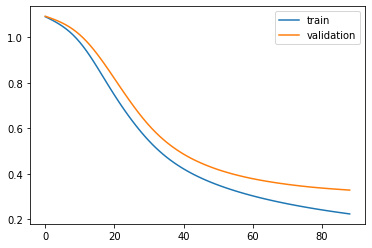

In [30]:
epochs = [i for i in range(len(loss_tr))]

plt.figure()
plt.plot(epochs, loss_tr, label="train")
plt.plot(epochs, dev_loss, label="validation")
plt.legend()

Compute accuracy, precision, recall and F1-Score:

In [31]:
Y_te = test_y
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8344444444444444
Precision: 0.8380941058774173
Recall: 0.8344444444444444
F1-Score: 0.8346405434130201


### Discuss how did you choose model hyperparameters ? 

In [32]:
embed_size_list = [100, 300]
dropout_rate_list = [0.2, 0.6]
lr_list = [0.001, 0.01]
tr_loss_history, dev_loss_history = [], []

for embed in embed_size_list:
    for dropout in dropout_rate_list:
        for lr in lr_list:
            W = network_weights(vocab_size=len(vocab),embedding_dim=embed,hidden_dim=[], num_classes=3)
            _, loss_tr, dev_loss = SGD(X_tr, train_y,W,X_dev=X_dev, Y_dev=dev_y,lr=lr, dropout=dropout,epochs=300, print_progress=False)
            print("hyperparameter embedding: {} dropout rate: {} learning rate: {} train loss: {} dev loss: {}".format(embed, dropout, lr, loss_tr[-1], dev_loss[-1]))
            tr_loss_history.append(loss_tr)
            dev_loss_history.append(dev_loss)

stop training.
hyperparameter embedding: 100 dropout rate: 0.2 learning rate: 0.001 train loss: 0.23086304962204365 dev loss: 0.34074055118956353
stop training.
hyperparameter embedding: 100 dropout rate: 0.2 learning rate: 0.01 train loss: 0.18178523539019337 dev loss: 0.32536926641648284
stop training.
hyperparameter embedding: 100 dropout rate: 0.6 learning rate: 0.001 train loss: 0.24846140025060928 dev loss: 0.34758090224941246
stop training.
hyperparameter embedding: 100 dropout rate: 0.6 learning rate: 0.01 train loss: 0.12130517882319869 dev loss: 0.332837530256572
stop training.
hyperparameter embedding: 300 dropout rate: 0.2 learning rate: 0.001 train loss: 0.22903067223147108 dev loss: 0.331350629949033
stop training.
hyperparameter embedding: 300 dropout rate: 0.2 learning rate: 0.01 train loss: 0.02296588982571945 dev loss: 0.45696160733922386
stop training.
hyperparameter embedding: 300 dropout rate: 0.6 learning rate: 0.001 train loss: 0.24702120355423843 dev loss: 0.342

'According to the figure below, hyper-parameter of 1, 3, 5, 7 is better than others. However, 5 is less time-consuming to converge. Therefore, the fifth parameter is the my choice.'

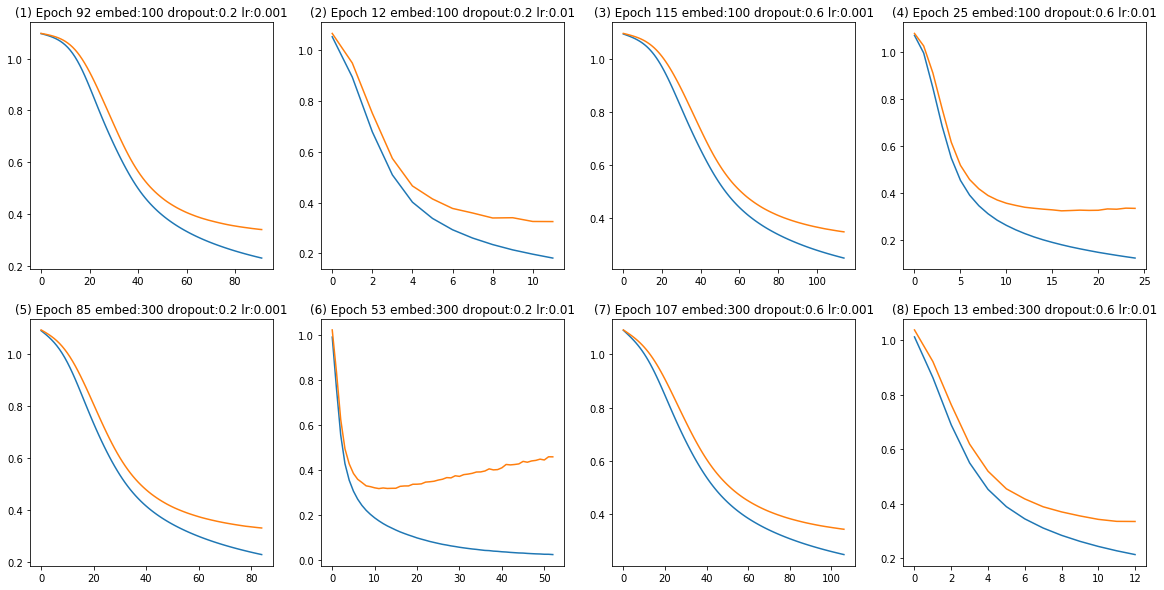

In [33]:
plt.figure(figsize=(20, 10))
for i in range(8):
    epochs = [i for i in range(len(tr_loss_history[i]))]
    pos = 241 + i
    plt.subplot(pos)
    embed = 100 if i < 4 else 300
    dropout = dropout_rate_list[0] if i ==0 or i == 1 or i == 4 or i == 5 else dropout_rate_list[1]
    lr = lr_list[0] if i ==0 or i == 2 or i == 4 or i == 6 else lr_list[1]
    plt.title("("+str(i+1)+") Epoch "+str(len(tr_loss_history[i]))+" embed:"+str(embed)+" dropout:"+str(dropout)+" lr:"+str(lr))
    plt.plot(epochs,tr_loss_history[i],label="train")
    plt.plot(epochs,dev_loss_history[i],label="validation")

"""According to the figure below, hyper-parameter of 1, 3, 5, 7 is better than others. However, 5 is less time-consuming to converge. Therefore, the fifth parameter is the my choice."""


# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [34]:
def get_glove_embeddings(f_txt, vocab, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    # with zipfile.ZipFile(f_zip) as z:
    with open(f_txt) as f:
        for line in f:
            #line = line.decode('utf-8')
            word = line.split()[0]

            if word in vocab:
                emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                w_emb[word2id[word]] +=emb
    return w_emb

In [35]:
w_glove = get_glove_embeddings("data_topic/glove.840B.300d.txt", vocab, vocab_dict)

In [36]:
w_glove.shape

(1000, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [37]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)

W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, train_y,
                            W,
                            X_dev=X_dev, 
                            Y_dev=dev_y,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=200)

Epoch:  0 | Training loss:  0.9976108096637533 | Validation loss:  1.011370698262269
Epoch:  1 | Training loss:  0.9181951755971774 | Validation loss:  0.9417376734105322
Epoch:  2 | Training loss:  0.8513336502572548 | Validation loss:  0.8780237896456717
Epoch:  3 | Training loss:  0.79658995390354 | Validation loss:  0.8261996853455127
Epoch:  4 | Training loss:  0.7515176778965023 | Validation loss:  0.7814342440266004
Epoch:  5 | Training loss:  0.713274833882654 | Validation loss:  0.7447358917566632
Epoch:  6 | Training loss:  0.680489311300622 | Validation loss:  0.7127316788046312
Epoch:  7 | Training loss:  0.654082925362232 | Validation loss:  0.6831802490645587
Epoch:  8 | Training loss:  0.630161497246209 | Validation loss:  0.6596510487997818
Epoch:  9 | Training loss:  0.6107698010194198 | Validation loss:  0.6392840781795299
Epoch:  10 | Training loss:  0.5918671296478503 | Validation loss:  0.6186738776606987
Epoch:  11 | Training loss:  0.5764565274736386 | Validation

In [38]:
Y_te = test_y
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8622222222222222
Precision: 0.8623231756719275
Recall: 0.8622222222222221
F1-Score: 0.8620313844556402


'It seems that using pre-trained word vector, the model is less overfitting.'

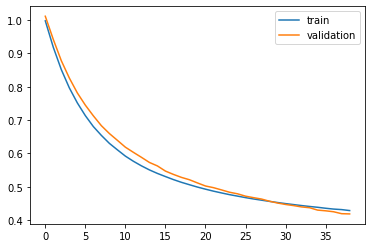

In [39]:
epochs = [i for i in range(len(loss_tr))]

plt.figure()
plt.plot(epochs, loss_tr, label="train")
plt.plot(epochs, dev_loss, label="validation")
plt.legend()

"""It seems that using pre-trained word vector, the model is less overfitting."""

### Discuss how did you choose model hyperparameters ? 

In [40]:
dropout_rate_list = [0.2, 0.6]
lr_list = [0.001, 0.01, 0.05]
tr_loss_history, dev_loss_history = [], []


for dropout in dropout_rate_list:
    for lr in lr_list:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)
        W[0] = w_glove
        _, loss_tr, dev_loss = SGD(X_tr, train_y,W,X_dev=X_dev, Y_dev=dev_y,lr=lr, dropout=dropout,epochs=300, print_progress=False, freeze_emb=True)
        print("hyperparameter dropout rate: {} learning rate: {} train loss: {} dev loss: {}".format(dropout, lr, loss_tr[-1], dev_loss[-1]))
        tr_loss_history.append(loss_tr)
        dev_loss_history.append(dev_loss)

stop training.
hyperparameter dropout rate: 0.2 learning rate: 0.001 train loss: 0.4481910515191217 dev loss: 0.4440693515743418
stop training.
hyperparameter dropout rate: 0.2 learning rate: 0.01 train loss: 0.30723530826444306 dev loss: 0.2704224138886574
stop training.
hyperparameter dropout rate: 0.2 learning rate: 0.05 train loss: 0.17614034673320333 dev loss: 0.29468279981168943
stop training.
hyperparameter dropout rate: 0.6 learning rate: 0.001 train loss: 0.46275663601532907 dev loss: 0.463832478424202
stop training.
hyperparameter dropout rate: 0.6 learning rate: 0.01 train loss: 0.33106268072255945 dev loss: 0.2878765771009434
stop training.
hyperparameter dropout rate: 0.6 learning rate: 0.05 train loss: 0.33163562150353787 dev loss: 0.2836974438390392


'According to the figure below, hyper-parameter of 1, 4 is better than others. However, 1 is less time-consuming to converge. Therefore, the first parameter is the my choice.'

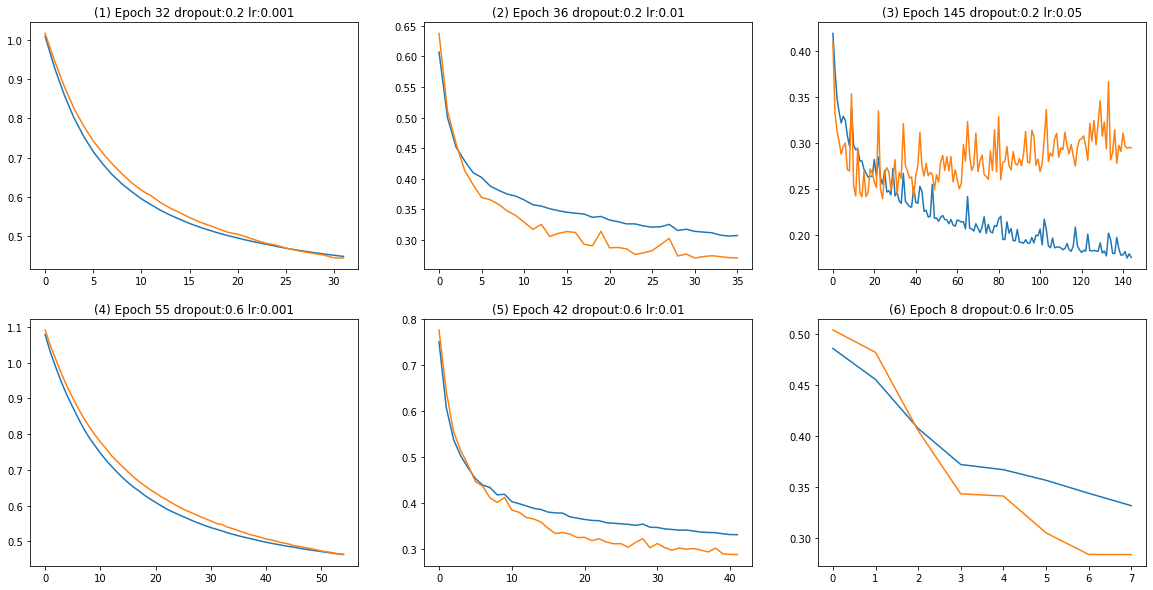

In [41]:
plt.figure(figsize=(20, 10))
for i in range(6):
    epochs = [i for i in range(len(tr_loss_history[i]))]
    pos = 231 + i
    plt.subplot(pos)
    dropout = dropout_rate_list[0] if i ==0 or i == 1 or i == 2 else dropout_rate_list[1]
    if i == 0 or i == 3: lr = lr_list[0]
    elif i == 1 or i == 4: lr = lr_list[1]
    else: lr = lr_list[2]
        
    plt.title("("+str(i+1)+") Epoch "+str(len(tr_loss_history[i]))+" dropout:"+str(dropout)+" lr:"+str(lr))
    plt.plot(epochs,tr_loss_history[i],label="train")
    plt.plot(epochs,dev_loss_history[i],label="validation")

"""According to the figure below, hyper-parameter of 1, 4 is better than others. However, 1 is less time-consuming to converge. Therefore, the first parameter is the my choice."""

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

### add one hidden layer with size 64:

In [42]:
dropout_rate_list = [0.2, 0.6]
lr_list = [0.001, 0.01, 0.05]
tr_loss_history, dev_loss_history = [], []


for dropout in dropout_rate_list:
    for lr in lr_list:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[64], num_classes=3)
        W[0] = w_glove
        _, loss_tr, dev_loss = SGD(X_tr, train_y,W,X_dev=X_dev, Y_dev=dev_y,lr=lr, dropout=dropout,epochs=50, tolerance=0, print_progress=False, freeze_emb=True)
        print("hyperparameter dropout rate: {} learning rate: {} train loss: {} dev loss: {}".format(dropout, lr, loss_tr[-1], dev_loss[-1]))
        tr_loss_history.append(loss_tr)
        dev_loss_history.append(dev_loss)

hyperparameter dropout rate: 0.2 learning rate: 0.001 train loss: 1.0674726607392795 dev loss: 1.0717045105480845
hyperparameter dropout rate: 0.2 learning rate: 0.01 train loss: 0.33117184093831836 dev loss: 0.2826071941493678
hyperparameter dropout rate: 0.2 learning rate: 0.05 train loss: 0.2786257800560037 dev loss: 0.2904958951166987
hyperparameter dropout rate: 0.6 learning rate: 0.001 train loss: 1.0930225025731264 dev loss: 1.0942435705623894
hyperparameter dropout rate: 0.6 learning rate: 0.01 train loss: 0.40591253298312047 dev loss: 0.314220585739558
hyperparameter dropout rate: 0.6 learning rate: 0.05 train loss: 0.40916287752200226 dev loss: 0.30444902478889624


'50 epoch is fixed because higher lr will cause overflow. it seems that 1, 2, 5 are better. As for the first, it needs long training time. However, there is less fluctuation. As for 2 and 5, it needs less training time but performance is not stable. In this case, the first was choosen.'

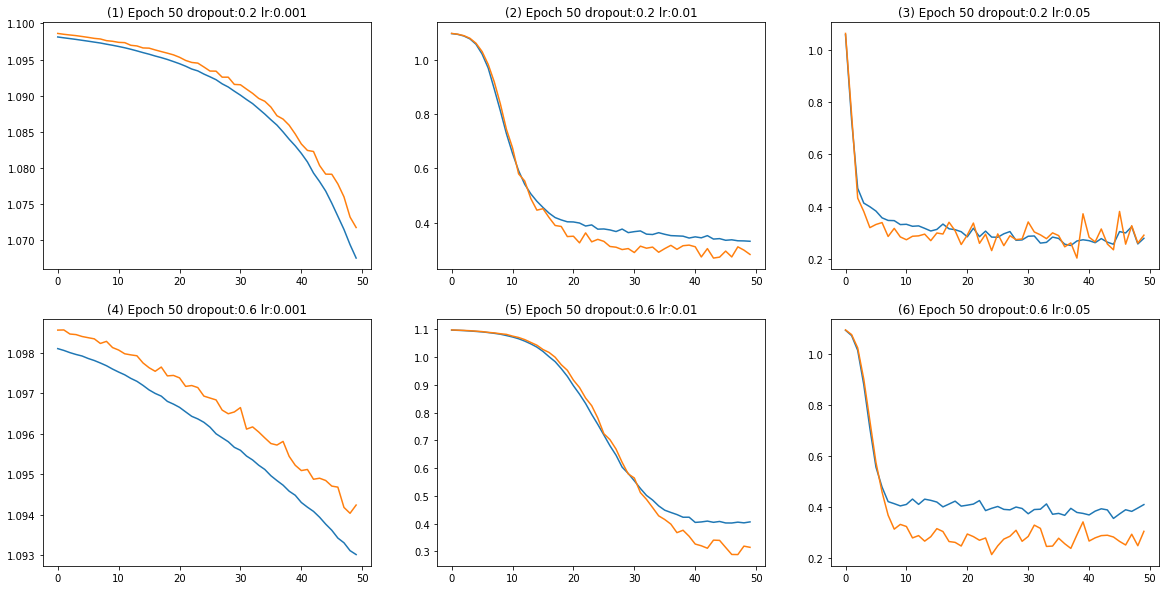

In [43]:
dropout_rate_list = [0.2, 0.6]
lr_list = [0.001, 0.01, 0.05]

plt.figure(figsize=(20, 10))
for i in range(6):
    epochs = [i for i in range(len(tr_loss_history[i]))]
    pos = 231 + i
    plt.subplot(pos)
    dropout = dropout_rate_list[0] if i ==0 or i == 1 or i == 2 else dropout_rate_list[1]
    if i == 0 or i == 3: lr = lr_list[0]
    elif i == 1 or i == 4: lr = lr_list[1]
    else: lr = lr_list[2]
        
    plt.title("("+str(i+1)+") Epoch "+str(len(tr_loss_history[i]))+" dropout:"+str(dropout)+" lr:"+str(lr))
    plt.plot(epochs,tr_loss_history[i],label="train")
    plt.plot(epochs,dev_loss_history[i],label="validation")
    
"""50 epoch is fixed because higher lr will cause overflow. it seems that 1, 2, 5 are better. As for the first, it needs long training time. However, there is less fluctuation. As for 2 and 5, it needs less training time but performance is not stable. In this case, the first was choosen."""

In [44]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[64], num_classes=3)

W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, train_y,
                            W,
                            X_dev=X_dev, 
                            Y_dev=dev_y,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0,
                            epochs=300)

Epoch:  0 | Training loss:  1.0980250920265269 | Validation loss:  1.0985035214456202
Epoch:  1 | Training loss:  1.0978857725504165 | Validation loss:  1.0984071228414398
Epoch:  2 | Training loss:  1.0977630977228443 | Validation loss:  1.0982513676689487
Epoch:  3 | Training loss:  1.0976077427554185 | Validation loss:  1.0981617871826437
Epoch:  4 | Training loss:  1.0974752879895733 | Validation loss:  1.0980598951097575
Epoch:  5 | Training loss:  1.0973206536036535 | Validation loss:  1.0978649832282619
Epoch:  6 | Training loss:  1.0971305078300595 | Validation loss:  1.0977173845473276
Epoch:  7 | Training loss:  1.0969770749379746 | Validation loss:  1.0975617714927963
Epoch:  8 | Training loss:  1.0967754233249623 | Validation loss:  1.0974214840331777
Epoch:  9 | Training loss:  1.0965869906025232 | Validation loss:  1.097396711953374
Epoch:  10 | Training loss:  1.0964035959050455 | Validation loss:  1.0970512362888762
Epoch:  11 | Training loss:  1.0961609975423139 | Vali

Epoch:  95 | Training loss:  0.759234410010682 | Validation loss:  0.7831518178420714
Epoch:  96 | Training loss:  0.7515037168566726 | Validation loss:  0.7724399052742762
Epoch:  97 | Training loss:  0.7358595650443603 | Validation loss:  0.7460532147168011
Epoch:  98 | Training loss:  0.7307738242710454 | Validation loss:  0.7456187868800431
Epoch:  99 | Training loss:  0.7209423666039698 | Validation loss:  0.7454572411632592
Epoch:  100 | Training loss:  0.7111864252514081 | Validation loss:  0.7377751036022439
Epoch:  101 | Training loss:  0.7083729069855506 | Validation loss:  0.726567845339006
Epoch:  102 | Training loss:  0.6996526707905937 | Validation loss:  0.7188724234074564
Epoch:  103 | Training loss:  0.6937117917506262 | Validation loss:  0.7050073572249167
Epoch:  104 | Training loss:  0.6867659268259504 | Validation loss:  0.6812650531084844
Epoch:  105 | Training loss:  0.6735120071244247 | Validation loss:  0.6895745428330897
Epoch:  106 | Training loss:  0.6709066

Epoch:  188 | Training loss:  0.41194507701998095 | Validation loss:  0.36775646562520015
Epoch:  189 | Training loss:  0.4075400085783232 | Validation loss:  0.35876896529314867
Epoch:  190 | Training loss:  0.4151348129482394 | Validation loss:  0.3469133194136299
Epoch:  191 | Training loss:  0.4143152967746652 | Validation loss:  0.4058259738548017
Epoch:  192 | Training loss:  0.4126880158438941 | Validation loss:  0.3559656720506137
Epoch:  193 | Training loss:  0.40525915033243803 | Validation loss:  0.3753485948511643
Epoch:  194 | Training loss:  0.4090344389460553 | Validation loss:  0.35004562811768225
Epoch:  195 | Training loss:  0.4046403383974779 | Validation loss:  0.37412817327685666
Epoch:  196 | Training loss:  0.405602658753775 | Validation loss:  0.3737534139788522
Epoch:  197 | Training loss:  0.40591734891389236 | Validation loss:  0.3503850868441105
Epoch:  198 | Training loss:  0.40471463263637303 | Validation loss:  0.3537643634643171
Epoch:  199 | Training lo

Epoch:  281 | Training loss:  0.37320697570289646 | Validation loss:  0.33041070827169505
Epoch:  282 | Training loss:  0.3678227967625507 | Validation loss:  0.3055890049777437
Epoch:  283 | Training loss:  0.3683388657464695 | Validation loss:  0.3135479853612555
Epoch:  284 | Training loss:  0.370407796966618 | Validation loss:  0.2933314202236784
Epoch:  285 | Training loss:  0.36739186999420864 | Validation loss:  0.32314356793731386
Epoch:  286 | Training loss:  0.3616171101449486 | Validation loss:  0.31651403180839416
Epoch:  287 | Training loss:  0.3601823934033467 | Validation loss:  0.3181399973804873
Epoch:  288 | Training loss:  0.3673821918826176 | Validation loss:  0.31041325191698266
Epoch:  289 | Training loss:  0.3599649185454685 | Validation loss:  0.30770392886614756
Epoch:  290 | Training loss:  0.3658976051839197 | Validation loss:  0.31805712758689264
Epoch:  291 | Training loss:  0.3642052639098807 | Validation loss:  0.3061625255251757
Epoch:  292 | Training lo

In [45]:
Y_te = test_y
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8611111111111112
Precision: 0.8622257949012561
Recall: 0.861111111111111
F1-Score: 0.8611059302829704


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  0.844 | 0.841  | 0.841  | 0.841  |
| Average Embedding (Pre-trained)  |  0.861 |  0.861 |  0.860 | 0.861  |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |  0.86 | 0.86  | 0.859  | 0.86  |
